In [1]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#### Maximum deviation (10% in this case)
devmax = 0.1

#### Change this to another cosmology if necessary
cosmo = ccl.CosmologyVanillaLCDM()

# Arrays at which power spectra will be evaluated.
#### Keep these as they are, because the IA profiles are
# kind of unstable at the default values of a used by
# CCL.
k_arr = np.geomspace(1E-3, 1e3, 256)
a_arr = np.linspace(0.1, 1, 16)


# Halo model stuff
cM = ccl.halos.ConcentrationDuffy08(mass_def="200m")
nM = ccl.halos.MassFuncTinker10(mass_def="200m")
bM = ccl.halos.HaloBiasTinker10(mass_def="200m")
prof_IA = ccl.halos.SatelliteShearHOD(mass_def="200m", concentration=cM, lmax=6, a1h=0.001)
prof_M = ccl.halos.HaloProfileNFW(mass_def="200m", concentration=cM)
hmc = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM, mass_def="200m")
pk_mm = ccl.halos.halomod_Pk2D(cosmo, hmc, prof_M, prof2=prof_M,
                               lk_arr=np.log(k_arr), a_arr=a_arr)
pk_im = ccl.halos.halomod_Pk2D(cosmo, hmc, prof_IA, prof2=prof_M,
                               lk_arr=np.log(k_arr), a_arr=a_arr, get_2h=False)
pk_ii = ccl.halos.halomod_Pk2D(cosmo, hmc, prof_IA, prof2=prof_IA,
                               lk_arr=np.log(k_arr), a_arr=a_arr, get_2h=False)

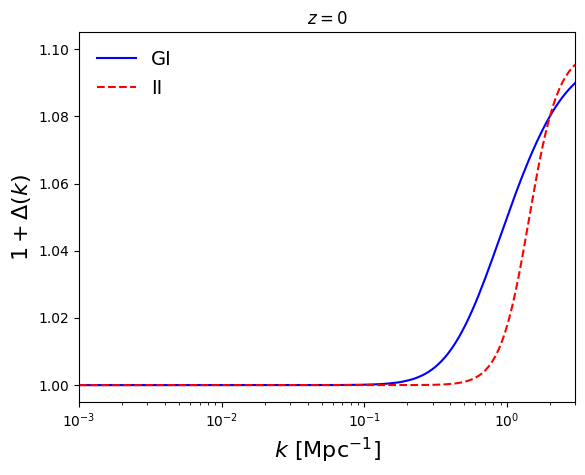

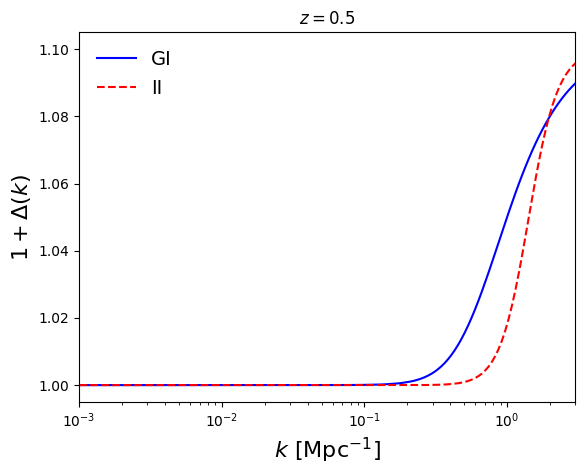

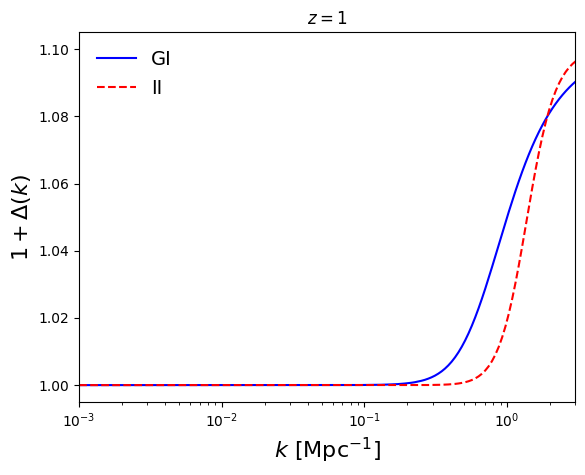

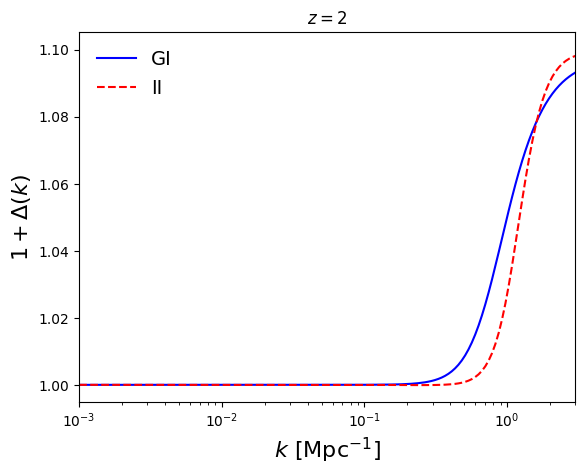

In [3]:
# Calculate multiplying amplitude to get X%
# deviation at k=2 Mpc^-1
kpiv = 1.0
norm_Im = np.array([-devmax * pk_mm(kpiv, a)/pk_im(kpiv, a)
                    for a in a_arr])

# This function provides a soft truncation of x
# at |x| = xmax
def softmax(x, xmax):
    y = x/xmax
    return x/(1+np.fabs(y))

Delta_GI = softmax(np.array([-n*pk_im(k_arr, a)/pk_mm(k_arr, a)
                             for n, a in zip(norm_Im, a_arr)]), devmax)
Delta_II = softmax(np.array([n**2*pk_ii(k_arr, a)/pk_mm(k_arr, a)
                             for n, a in zip(norm_Im, a_arr)]), devmax)
pk_mm_arr = np.array([pk_mm(k_arr, a) for a in a_arr])
pk_GI_arr = pk_mm_arr * (1+Delta_GI)
pk_II_arr = pk_mm_arr * (1+Delta_II)

# Alright, here are the final Pk2D objects
pk_GI = ccl.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), pk_arr=np.log(pk_GI_arr), is_logp=True)
pk_II = ccl.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), pk_arr=np.log(pk_II_arr), is_logp=True)

# Now let's plot the deviation at different redshifts for sanity
for z in [0, 0.5, 1, 2]:
    a = 1/(1+z)
    plt.figure()
    plt.title(f'$z={z}$')
    plt.plot(k_arr, pk_GI(k_arr, a) / pk_mm(k_arr, a), 'b-', label='GI')
    plt.plot(k_arr, pk_II(k_arr, a) / pk_mm(k_arr, a), 'r--', label='II')
    plt.xscale('log')
    plt.xlim([1E-3, 3])
    plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=16)
    plt.ylabel(r'$1+\Delta(k)$', fontsize=16)
    plt.legend(fontsize=14, frameon=False)